# Parameter estimation in Gaussian mixture models

In [1]:
using DynamicPolynomials
using MultivariateMoments
using SemialgebraicSets

using Distributions
using PDMats

using Plots
using Plots.PlotMeasures
using PyPlot
using Formatting

using HCubature

const MM=MultivariateMoments

include("../src/BeurlingLasso.jl")
using .BeurlingLasso;

┌ Info: Recompiling stale cache file /home/rom1/.julia/compiled/v1.1/Distributions/xILW0.ji for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/rom1/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/rom1/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/rom1/.julia/compiled/v1.1/HCubature/kjNeM.ji for HCubature [19dc6840-f33b-545b-b366-655c7e3ffd49]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/rom1/.julia/compiled/v1.1/SumOfSquares/VZKsW.ji for SumOfSquares [4b9e565b-77fc-50a5-a571-1244f986bda1]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/rom1/.julia/compiled/v1.1/Optim/R5uoh.ji for Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1184
┌ Info: Reco

In [2]:
pyplot()
PyPlot.matplotlib.rc("text", usetex=true)
PyPlot.matplotlib.rc("font", family="serif")
Plots.scalefontsizes(1.5)

## 1D example

In [3]:
means = [[-0.8], [0.7]]
weights = [0.3, 0.7]

σ = 0.5

natoms = length(means)
ndims = length(means[1])

@polyvar x[1:ndims]
μ0 = AtomicMeasure(x, [WeightedDiracMeasure(means[i], weights[i]) for i=1:natoms]);

In [4]:
identity = ScalMat(ndims, σ^2)
gmm = MixtureModel(MvNormal, [(mean, identity) for mean in means], weights);

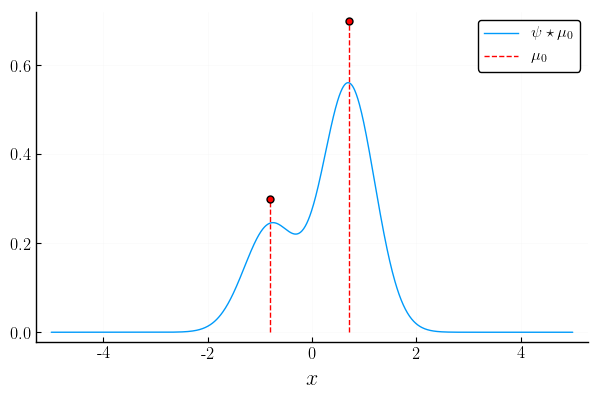

In [6]:
x_tab = -5:0.01:5
y_tab = pdf(gmm, reshape(x_tab, 1, length(x_tab)))

Plots.plot(x_tab, y_tab, label=L"$\psi\star \mu_0$", 
           right_margin=5mm, top_margin=5mm, gridcolor="lightgrey")

plot!([atom.center[1] for atom in μ0.atoms], [atom.weight for atom in μ0.atoms], 
      line=:stem, linestyle=:dash, marker=:circle, markersize=5, color="red", label=L"$\mu_0$")

plot!(xlabel=L"$x$")
Plots.savefig("deconv.eps")

## Parameters estimation

Computation of $\Phi\mu_0$ assuming access to $\mu_0$

In [11]:
maxorder = 5

monos = monomials(x, 0:maxorder)
m = length(monos)
y = [MM.expectation(μ0, monos[i]) for i=1:m]

λ = 1e-5;

### Parameters estimation using moments - sums of squares hierarchies

In [12]:
φ = [polynomial(mono) for mono in monos]
domain = @set x[1] <= 1 && x[1] >= -1;

In [13]:
ϵ = 1e-3
solver = momsossolver(ϵ);

In [14]:
prob = blasso(y, φ, λ, domain)
solve!(prob, solver);

Internal error: encountered unexpected error in runtime:
InterruptException()
jl_mutex_unlock at /buildworker/worker/package_linux64/build/src/locks.h:138 [inlined]
jl_typeinf_end at /buildworker/worker/package_linux64/build/src/gf.c:2623
typeinf_ext at ./compiler/typeinfer.jl:577
typeinf_ext at ./compiler/typeinfer.jl:613
jfptr_typeinf_ext_1.clone_1 at /home/rom1/packages/julias/julia-1.1.1/lib/julia/sys.so (unknown line)
jl_apply_generic at /buildworker/worker/package_linux64/build/src/gf.c:2197
jl_apply at /buildworker/worker/package_linux64/build/src/julia.h:1571 [inlined]
jl_type_infer at /buildworker/worker/package_linux64/build/src/gf.c:255
jl_compile_method_internal at /buildworker/worker/package_linux64/build/src/gf.c:1797 [inlined]
jl_fptr_trampoline at /buildworker/worker/package_linux64/build/src/gf.c:1841
jl_apply_generic at /buildworker/worker/package_linux64/build/src/gf.c:2197
supports_constraint at /home/rom1/.julia/packages/MathOptInterface/C3lip/src/Utilities/caching

InterruptException: InterruptException:

In [15]:
prob.μ

### Parameters estimation using the sliding Frank-Wolfe algorithm

In [16]:
φ_func(u, n) = monos[n](x=>u)
domain = reshape([-1, 1], (1, 2));

In [17]:
niter = 2
gridsize = 1000
solver = sfwsolver(niter, gridsize);

In [18]:
# prob = blasso(y, φ_func, λ, domain)
# solve!(prob, solver);

In [19]:
# prob.μ

## Moments approximation

$$\int_{\mathcal{X}}\varphi_n(x)~d\mu=\mathbb{E}_{X\sim f_{\mu}}[\phi_n(X)]$$ 

with $\varphi_n(x)=x^n ~ \text{exp}(-\frac{x^2}{2\tau^2})$ and 
$\phi_n(x)\propto H_n\left(\frac{x}{\sqrt{2\sigma^2\left(1-\frac{\sigma^2}{\tau^2}\right)}}\right) 
~ \text{exp}(-\frac{x^2}{2(\tau^2-\sigma^2)})$ 

In [26]:
τ = sqrt(2) * σ;

In [27]:
maxorder = 15
a = computehermite(maxorder)

function hermite(x, n)
    sum(a[n+1, k+1] * x^k for k=0:n)
end

function ϕ(x, n, σ, τ)
    const1 = sqrt(τ^2/(τ^2-σ^2))
    const2 = sqrt(σ^2/(2*(1-σ^2/τ^2)))^n
    expterm = exp(-x^2/(2*(τ^2-σ^2)))
    hterm = hermite(x/sqrt(2*σ^2*(1-σ^2/τ^2)), n)
    regconst = sqrt(2^n * factorial(n) * sqrt(π))
    const1 * const2 * expterm * hterm / regconst
end;

In [28]:
using HCubature

In [29]:
function compute_err(σ, k, n, nsamplestab)
    samples = rand(gmm, Integer(max(nsamplestab...)))
    truth = hquadrature(x -> ϕ(x, n, σ, sqrt(k)*σ) * pdf(gmm, [x]), -30, 30)[1]
    estim = []
    count = 1
    tempsum = 0
    for nsamples in nsamples_tab
        tempsum += sum(ϕ(sample, n, σ, sqrt(k)*σ) for sample in samples[count:Integer(nsamples-1)])
        append!(estim, tempsum / nsamples)
        count = Integer(nsamples)
    end
    abs.(estim .- truth) / truth
end;

In [56]:
function compute_err_bis(σ, k, n, nsamplestab)
    res = compute_err(σ, k, n , nsamplestab)
    for i=1:29
        res = res .+ compute_err(σ, k, n, nsamplestab)
    end
    res / 30
end

compute_err_bis (generic function with 1 method)

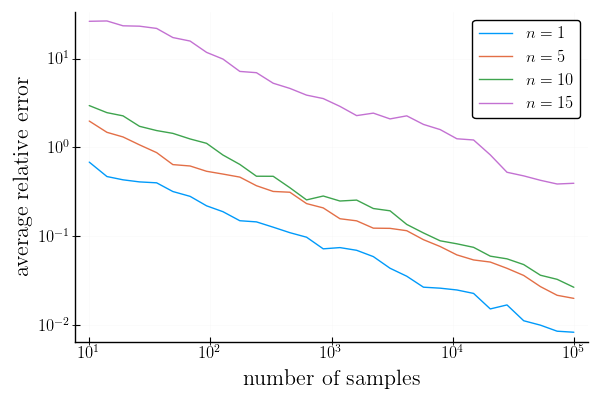

In [61]:
nsamples_tab = ceil.(10 .^(range(1,stop=5,length=30)))
y = [compute_err_bis(1, 2, n, nsamples_tab) for n in [1 5 10 15]]
Plots.plot(nsamples_tab, hcat(y...), xaxis=:log, yaxis=:log, label=[L"$n=1$" L"$n=5$" L"$n=10$" L"$n=15$"],
           xlabel="number of samples", ylabel="average relative error", top_margin=5mm, right_margin=5mm,
           gridcolor="lightgrey")
Plots.savefig("errmom.eps")

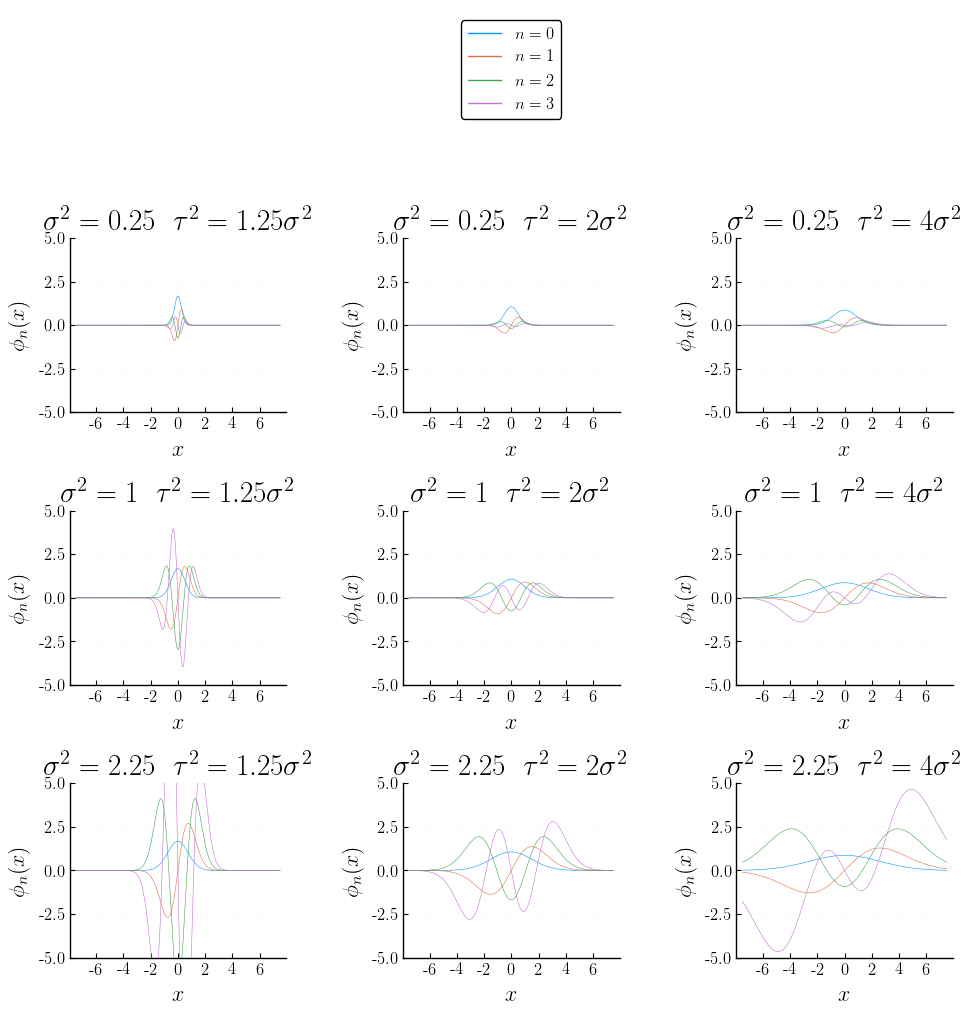

In [140]:
felab = FormatExpr(L"$n={}$")
fetitle = FormatExpr(L"$\sigma^2={1}~~\tau^2={2}\sigma^2$")

x_tab = -7.5:0.01:7.5
n_tab = [0 1 2 3]

function plot_ϕ(σ, k, leg)
    y_tab = hcat([[ϕ(x, n, σ, sqrt(k)*σ) for x in x_tab] for n in n_tab]...)
    Plots.plot(x_tab, y_tab, ylims=(-5, 5),
               xlabel=L"x", ylabel=L"\phi_n(x)", top_margin=5mm, right_margin=10mm,
               title=format(fetitle, σ^2, k), legend=leg, gridcolor="lightgrey", linewidth=0.4)
end


p1 = plot_ϕ(0.5, 1.25, false)
p2 = plot_ϕ(0.5, 2, false)
p3 = plot_ϕ(0.5, 4, false)

p4 = plot_ϕ(1, 1.25, false)
p5 = plot_ϕ(1, 2, false)
p6 = plot_ϕ(1, 4, false)

p7 = plot_ϕ(1.5, 1.25, false)
p8 = plot_ϕ(1.5, 2, false)
p9 = plot_ϕ(1.5, 4, false)

l = @layout[a; [b c d]; [e f g]; [h i j]]

Plots.plot(Plots.plot((1:4)', label=hcat([format(felab, n) for n in n_tab]...), legend = :top, framestyle = :none), 
           p1, p2, p3, p4, p5, p6, p7, p8, p9,
           layout=l, size = (1000, 1000), link=:y,
           left_margin=5mm, right_margin=10mm)

Plots.savefig("phi_n.eps")

Computation of $\text{Var}_{X\sim f_{\mu}}[\phi_n(X)]$

In [18]:
squared_exp = [hquadrature(u -> ϕ(u, n)^2 * pdf(gmm, [u]), -10, 10)[1] for n in n_tab]
exp_squared = [hquadrature(u -> ϕ(u, n)^2 * pdf(gmm, [u]), -10, 10)[1]^2 for n in n_tab]
var = squared_exp .- exp_squared

1×5 Array{Float64,2}:
 0.217791  0.0828005  0.0212145  0.000233634  2.69434e-6

The variance seems to decrease with $n$

Approximation of $\mathbb{E}_{X\sim f_{\mu}}[\phi_n(X)]$ by $\frac{1}{N}\sum\limits_{i=1}^N\phi_n(X_i)$ 
with $X_1,...,X_n$ iid,  $X_i\sim f_{\mu}$

In [19]:
nsamples = 1000
samples = rand(gmm, nsamples);

In [20]:
moments_estim = [sum(ϕ(u, n) for u in samples) / nsamples for n in n_tab];

Approximation of $\mathbb{E}_{X\sim f_{\mu}}[\phi_n(X)]$ by 
$\int_{\mathcal{X}}\phi_n(x) ~ f_{\mu}(x)~dx$ (really reliable, will be considered ground truth)

In [21]:
moments_quad = [hquadrature(u -> ϕ(u, n) * pdf(gmm, [u]), -10, 10)[1] for n in n_tab];

In [22]:
abs.(moments_estim .- moments_quad) ./ moments_quad

1×5 Array{Float64,2}:
 0.0282605  0.159321  0.0590352  0.974953  4.78108

The estimation's relative precision however decreases with $n$, because moments become really small

In [23]:
nsamples = 1000000
samples = rand(gmm, nsamples)
moments_estim = [sum(ϕ(u, n) for u in samples) / nsamples for n in n_tab]

abs.(moments_estim .- moments_quad) ./ moments_quad

1×5 Array{Float64,2}:
 0.000255623  0.00139294  0.000772925  0.0956052  0.304429

Increasing the number of samples yields a better precision, but convergence is extremly slow for higher order moments

### Different choices of $\tau$ for each $n$

In [24]:
function ϕ(x, n, τ, σ)
    const1 = sqrt(τ^2/(τ^2-σ^2))
    const2 = sqrt(σ^2/(2*(1-σ^2/τ^2)))^n
    expterm = exp(-x^2/(2*(τ^2-σ^2)))
    hterm = hermite(x/sqrt(2*σ^2*(1-σ^2/τ^2)), n)
    regconst = sqrt(2^n * factorial(n) * sqrt(π))
    const1 * const2 * expterm * hterm / regconst
end;

In [25]:
r_tab = 1 .+ 10 .^(range(-4,stop=2,length=20))
y_tab = [hquadrature(u -> ϕ(u, 5, r*σ, σ) * pdf(gmm, [u]), -10, 10)[1] 
         for r in r_tab];

In [26]:
hquadrature(u -> ϕ(u, 3, 1.4*σ, σ) * pdf(gmm, [u]), -10, 10)[1]

0.007121483949355048

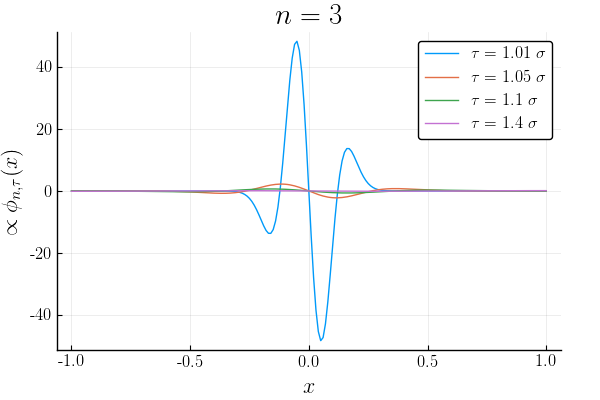

In [27]:
felab = FormatExpr(L"$\tau={}~\sigma$")

x_tab = -1:0.01:1
k_tab = [1.01 1.05 1.1 1.4]
y_tab = hcat([[ϕ(x, 3, k*σ, σ) for x in x_tab] for k in k_tab]...)

p = Plots.plot(x_tab, y_tab, label=hcat([format(felab, k) for k in k_tab]...),
               title=L"$n=3$", xlabel=L"$x$", ylabel=L"\propto\phi_{n,\tau}(x)",
               right_margin=10mm)